In [25]:
from IPython.display import display, Math

fourier_transform = r"""\boxed{\begin{array}{c}
\text{Fourier transform} \\[10pt]
\hat{f}(\xi) = \int_{-\infty}^{\infty} f(x) e^{-i 2 \pi \xi x} \, dx \quad
\end{array}}"""

display(Math(fourier_transform))


<IPython.core.display.Math object>

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [27]:
data_path = "../data/raw/waterDataTraining.csv"
df = pd.read_csv(data_path)
df.head(5)

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03T09:49:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2016-08-03T09:50:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,2016-08-03T09:51:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,2016-08-03T09:52:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,2016-08-03T09:53:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


In [28]:
def data_preprocessing(df, columns_to_drop):
    processed_df = df.copy()
    processed_df['Time'] = pd.to_datetime(processed_df['Time'])
    processed_df.set_index('Time', inplace=True)
    processed_df.drop(columns=columns_to_drop, inplace=True)
    processed_df['pH'].interpolate(method='time', inplace=True)
    
    return processed_df

columns_to_drop = ['Tp', 'Cl', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm','Fm_2']
processed_df = data_preprocessing(df, columns_to_drop)

/var/folders/x9/wfxfy30n21j10t1dqkkhfjjm0000gn/T/ipykernel_2705/379880480.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['pH'].interpolate(method='time', inplace=True)


In [29]:
processed_df.head()

,pH,EVENT
Time,,
2016-08-03 09:49:00+00:00,8.36,False
2016-08-03 09:50:00+00:00,8.36,False
2016-08-03 09:51:00+00:00,8.35,False
2016-08-03 09:52:00+00:00,8.35,False
2016-08-03 09:53:00+00:00,8.35,False


In [30]:
from numpy.fft import fft

pH_values = processed_df['pH'].values
pH_fft = fft(pH_values)

In [31]:
# Calculate the magnitudes
magnitudes = np.abs(pH_fft)

# Identify significant frequencies
significant_freqs = np.argsort(magnitudes)[-10:]


In [32]:
from numpy.fft import ifft

# Zero out non-significant frequencies
filtered_fft = np.copy(pH_fft)
filtered_fft[~np.isin(np.arange(len(filtered_fft)), significant_freqs)] = 0

# Inverse FFT to reconstruct the signal
reconstructed_signal = ifft(filtered_fft)

In [33]:
deviation = np.abs(pH_values - reconstructed_signal)

# Use mean and standard deviation to define the threshold
mean_deviation = np.mean(deviation)
std_deviation = np.std(deviation)

# Define the threshold
threshold = mean_deviation + 2 * std_deviation

# Identify anomalies
anomalies = deviation > threshold

# Update the DataFrame
processed_df['FFT_Anomaly'] = anomalies


In [34]:
# Compare original and reconstructed signals
anomalies = np.abs(pH_values - reconstructed_signal) > threshold

# Update the DataFrame
processed_df['FFT_Anomaly'] = anomalies

In [37]:
processed_df.head()

,pH,EVENT,FFT_Anomaly
Time,,,
2016-08-03 09:49:00+00:00,8.36,False,False
2016-08-03 09:50:00+00:00,8.36,False,False
2016-08-03 09:51:00+00:00,8.35,False,False
2016-08-03 09:52:00+00:00,8.35,False,False
2016-08-03 09:53:00+00:00,8.35,False,False


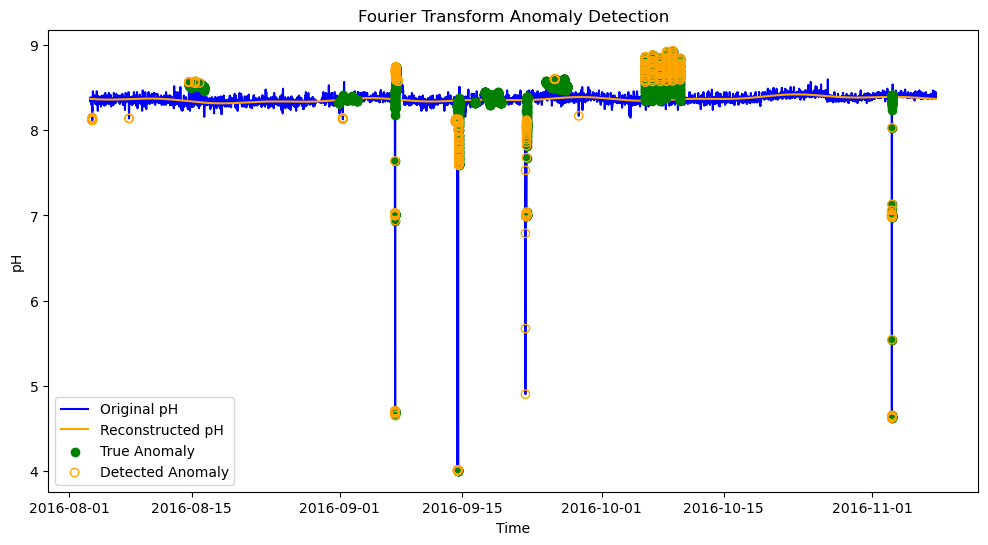

In [43]:
def plot_fft_anomalies(df, original_signal, reconstructed_signal, anomalies):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, original_signal, label='Original pH', color='blue')
    plt.plot(df.index, reconstructed_signal, label='Reconstructed pH', color='orange')
    plt.scatter(df.index[df['EVENT']], df['pH'][df['EVENT']], color='green', label='True Anomaly', zorder=5)
    plt.scatter(df.index[anomalies], original_signal[anomalies], facecolors='none', edgecolors='orange', label='Detected Anomaly', zorder=6)
    plt.legend()
    plt.title('Fourier Transform Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('pH')
    plt.show()

plot_fft_anomalies(processed_df, pH_values, reconstructed_signal, anomalies)

In [38]:
precision = precision_score(processed_df['EVENT'], processed_df['FFT_Anomaly'])
recall = recall_score(processed_df['EVENT'], processed_df['FFT_Anomaly'])
f1 = f1_score(processed_df['EVENT'], processed_df['FFT_Anomaly'])

In [40]:
print(precision, recall, f1)

0.8853383458646616 0.2728852838933951 0.4171833480956599
